In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from importlib import reload
import datetime
from glob import glob
import json

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\lamf_analysis_lims\gene_panel_selection\mfishtoolspy')
import mfishtools

# paths to the data
data_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\data\mouse_VISp_gene_expression_matrices_2018-06-14')
output_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\results')

In [2]:
# load and pre-process data (takes about 1 min)

# read annotation
annotation = pd.read_feather(data_folder / 'anno.feather')
# read data
# TODO: check where this data is coming from. Values are similar to cpm but not exactly the same
cpm_data = pd.read_feather(data_folder / 'exon_cpm.feather')
tpm_data = pd.read_feather(data_folder / 'exon_tpm.feather')

annotation.set_index('sample_id', inplace=True, drop=True)
# data.set_index('gene', inplace=True, drop=True) # only necessary with data_t.feather

# preprocessing
# Removing 'X" in column? from Hannah's code. Don't know when this happens, but leave them here just in case.
if 'X' in cpm_data.columns:
    print('Dropping "X" column from data')
    cpm_data = cpm_data.drop(columns=['X'])
if 'X' in tpm_data.columns:
    print('Dropping "X" column from data')
    tpm_data = tpm_data.drop(columns=['X']) 
if 'X' in annotation.columns:
    print('Dropping "X" column fro annotation')
    annotation = annotation.drop(columns=['X'])

# change the row order of annotation to match the order of columns in data
# annotation = annotation.loc[data.columns]  # don't need this, but add assert statement to check
assert np.all(annotation.index.values == tpm_data.columns.values)
assert np.all(annotation.index.values == cpm_data.columns.values)

# data conversion to log2
tpm_log2 = np.log2(tpm_data + 1)
cpm_log2 = np.log2(cpm_data + 1)

# read supertype information
# TODO: re-define supertype (will be addressed in another notebook)
supertype_folder = Path('//allen/programs/mindscope/workgroups/omfish/hannahs/mfish_project/gene_panels')
supertype_fn = supertype_folder / 'tasic2018_supertypes_manual_v2.xlsx'
sheet_name = 'all_supertypes_v2'
supertype = pd.read_excel(supertype_fn, sheet_name=sheet_name)
supertype.rename(columns={'Cell Type': 'cell_type', 'Supertype': 'supertype'}, inplace=True)
supertype.cell_type = supertype.cell_type.str.replace('\xa0', ' ')
supertype.supertype = supertype.supertype.str.replace('\xa0', ' ')
assert np.all([ct in annotation['cluster_label'].values for ct in supertype.cell_type.values])
supertype.set_index('cell_type', inplace=True, drop=True)

annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_33068\2181021420.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)


# Using a specific genes

In [3]:
ops = {
    # 'panel_name': 'Pan-neuronal', # GABAergic or Glutamatergic or Pan-neuronal
    'panel_name': 'GABAergic', # GABAergic or Glutamatergic or Pan-neuronal
    # 'full_panel_size': 28,
    'full_panel_size': 20,
    # 'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip","Cck","Tac1","Npy","Crh","Necab1","Ptprt","Kirrel3","Penk","Hpse","Calb2","Chodl"],
    'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip", "Sncg", "Lamp5", "Npy", "Calb2", "Tac1", "Cck", "Ndnf", 
                        "Reln", "Tac2", "Calb1", "Penk", "Crh", "Chat", "Nos1", "Ptprt", "Pdyn", "Pthlh"],
    'layer_1234_filter': True,
    'GABAergic_group_level': 'cluster', # class, subclass, supertype, or cluster
    'GABAergic_mapping_level': 'cluster',
    'Glutamatergic_group_level': 'subclass', # class, subclass, supertype, or cluster
    'Glutamatergic_mapping_level': 'subclass',
    'GABAergic_other_group_level': 'subclass', # class, subclass, supertype, or cluster
    'GABAergic_other_mapping_level': 'subclass',
    'Glutamatergic_other_group_level': 'class', # class, subclass, supertype, or cluster
    'Glutamatergic_other_mapping_level': 'class',
    'blend_supertypes': False,  # Don't know if I'm going to keep this
    'remove_redundant_genes': False, # from the starting_genes list
    'remove_redundant_genes_threshold': 0.95, # threshold for removing redundant genes from normalized accuracy
    'L1234_layer_threshold': 0.15,
    'L6_layer_threshold': 0.7,
    'L1234_labels': ['L1', 'L1-L2/3', 'L1-L4', 'L2/3', 'L2/3-L4', 'L4'],
    'L6_labels': ['L6', 'L6b'],
    'max_on': 5000,
    'max_off': 1129,
    'min_on': 10,
    'max_fraction_on_clusters': 0.5,
    'num_subsample': 50,
}

In [5]:
# preprocess options
if 'GABAergic' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic']
elif 'Glutamatergic' in ops['panel_name']:
    ops['keep_class'] = ['Glutamatergic']
elif 'Pan-neuronal' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic', 'Glutamatergic']
else:
    raise ValueError('panel_name must be GABAergic, Glutamatergic, or Pan-neuronal')

level_hierarchy = {'class': 0, 'subclass': 1, 'supertype': 2, 'cluster': 3}
assert level_hierarchy[ops['GABAergic_group_level']] <= level_hierarchy[ops['GABAergic_mapping_level']]
assert level_hierarchy[ops['GABAergic_other_group_level']] <= level_hierarchy[ops['GABAergic_other_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_group_level']] <= level_hierarchy[ops['Glutamatergic_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_other_group_level']] <= level_hierarchy[ops['Glutamatergic_other_mapping_level']]


In [6]:

keep_groups = []
keep_mappings = []
other_groups = []
other_mappings = []

if 'Glutamatergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["Glutamatergic_group_level"]}_label'
    group_label_list = [f'Glutamatergic {gl}' for gl in annotation.loc[annotation.class_label == 'Glutamatergic', group_level_label]] # To disambiguate from GABAergic groups
    annotation.loc[annotation.class_label == 'Glutamatergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["Glutamatergic_mapping_level"]}_label'
    mapping_label_list = [f'Glutamatergic {ml}' for ml in annotation.loc[annotation.class_label == 'Glutamatergic', mapping_label]] # To disambiguate from GABAergic mappings
    annotation.loc[annotation.class_label == 'Glutamatergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    if ops['Glutamatergic_group_level'] == 'class':
        keep_groups += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_groups += [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_group_level_label = f'{ops["Glutamatergic_other_group_level"]}_label'
            temp_other_groups = [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'Glutamatergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['Glutamatergic_mapping_level'] == 'class':
        keep_mappings += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_mappings += [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_mapping_level_label = f'{ops["Glutamatergic_other_mapping_level"]}_label'
            temp_other_mappings = [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'Glutamatergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# Same for GABAergic
# Except for filtering, now we are using scRNAseq layer-enriched data with thresholds
if 'GABAergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["GABAergic_group_level"]}_label'
    group_label_list = [f'GABAergic {gl}' for gl in annotation.loc[annotation.class_label == 'GABAergic', group_level_label]] # To disambiguate from Glutamatergic groups
    annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["GABAergic_mapping_level"]}_label'
    mapping_label_list = [f'GABAergic {ml}' for ml in annotation.loc[annotation.class_label == 'GABAergic', mapping_level_label]] # To disambiguate from Glutamatergic mappings
    annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    # Also need to name them different (adding L5 in front of the group and mapping labels)
    if ops['GABAergic_group_level'] == 'class':
        keep_groups += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process based on the layer abundance
            layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
            layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
            prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)
            L1234_prop_sum = prop_table.loc[ops['L1234_labels']].sum(axis=0)
            L1234_inh_types = set(L1234_prop_sum[L1234_prop_sum >= ops['L1234_layer_threshold']].index.values)
            not_L1234_inh_types = set(layer_df.cluster_label).difference(L1234_inh_types)
            L6_prop_sum = prop_table.loc[ops['L6_labels']].sum(axis=0)
            L6_inh_types = set(L6_prop_sum[L6_prop_sum >= ops['L6_layer_threshold']].index.values)
            L5_inh_types = not_L1234_inh_types.difference(L6_inh_types)
            # L1234_inh_types are going to be kept
            # L5_inh_types are going to be "other"
            # Ignore L6_inh_types (assume they won't be imaged)
            keep_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L1234_inh_types)]
            other_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L5_inh_types)]
            
            keep_groups += keep_annotation['group_label'].unique().tolist()

            # Process "other" groups
            other_group_level_label = f'{ops["GABAergic_other_group_level"]}_label'
            temp_other_groups = other_annotation['group_label'].unique().tolist()
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'GABAergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['GABAergic_mapping_level'] == 'class':
        keep_mappings += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process should have been done already in the above if clause
            # keep_annotation and other_annotation are already defined
            keep_mappings += keep_annotation['mapping_label'].unique().tolist()
            
            # Process "other" groups
            other_mapping_level_label = f'{ops["GABAergic_other_mapping_level"]}_label'
            temp_other_mappings = other_annotation['mapping_label'].unique().tolist()
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'GABAergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# assign cluster to nan mapping labels
# for filtering using "off clusters" information (e.g., glial cells)
annotation.loc[annotation['mapping_label']=='nan', 'mapping_label'] = annotation.loc[annotation['mapping_label']=='nan', 'cluster_label'] 

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_33068\3279224458.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_33068\3279224458.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list


In [8]:
ops['keep_mappings'] = keep_mappings
ops['other_mappings'] = other_mappings
ops['keep_groups'] = keep_groups
ops['other_groups'] = other_groups

In [9]:

# calculate proportions and medians for mapping labels and for group labels
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
tpm_log2_cluster = tpm_log2.copy().T
gene_column_names = list(tpm_log2_cluster.columns)
assert np.all(tpm_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
tpm_log2_cluster['mapping_label'] = annotation['mapping_label']
tpm_log2_cluster['group_label'] = annotation['group_label']
tpm_median_per_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').median().T
tpm_prop_expr_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
tpm_median_per_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').median().T
tpm_prop_expr_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(tpm_prop_expr_mapping.index.values == tpm_median_per_mapping.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_median_per_group.index.values)
assert np.all(tpm_prop_expr_mapping.index.values == tpm_log2.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_log2.index.values)

In [11]:
run_genes = ops['starting_genes']
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values

map_data = tpm_log2.loc[run_genes, keep_samples]
mapping_median_data = tpm_median_per_mapping.loc[run_genes, run_mappings]
cluster_call = annotation.loc[keep_samples, 'mapping_label']

corr_matrix_df = mfishtools.cor_tree_mapping(map_data,
median_data=mapping_median_data,
genes_to_map=run_genes)

[ 0.          0.          3.54598177  9.22949461 12.22866611 14.13421707
 15.90720795 17.61391881 36.15575808 40.54681027 46.16404308 46.77713339
 49.01408451 50.6048053  52.11267606 55.70836785 56.66942833 59.18806959
 60.21541011 61.77299089 62.96603148 62.36951118]


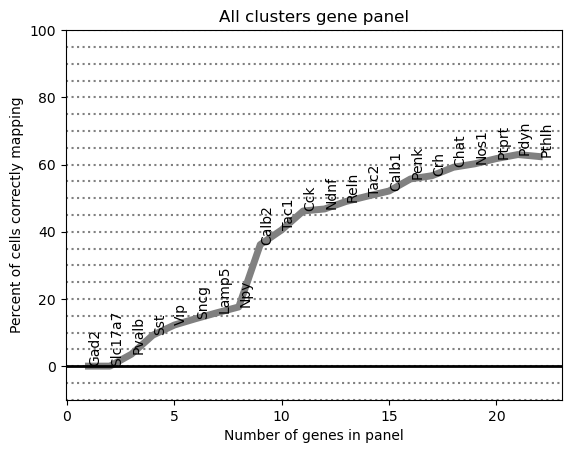

In [12]:
fig, ax = plt.subplots()
frac, ax = mfishtools.fraction_correct_with_genes(run_genes, map_data, mapping_median_data,
cluster_call=cluster_call, ax=ax)
print(frac)

Text(0.5, 1.0, 'Hand-picked 20 genes')

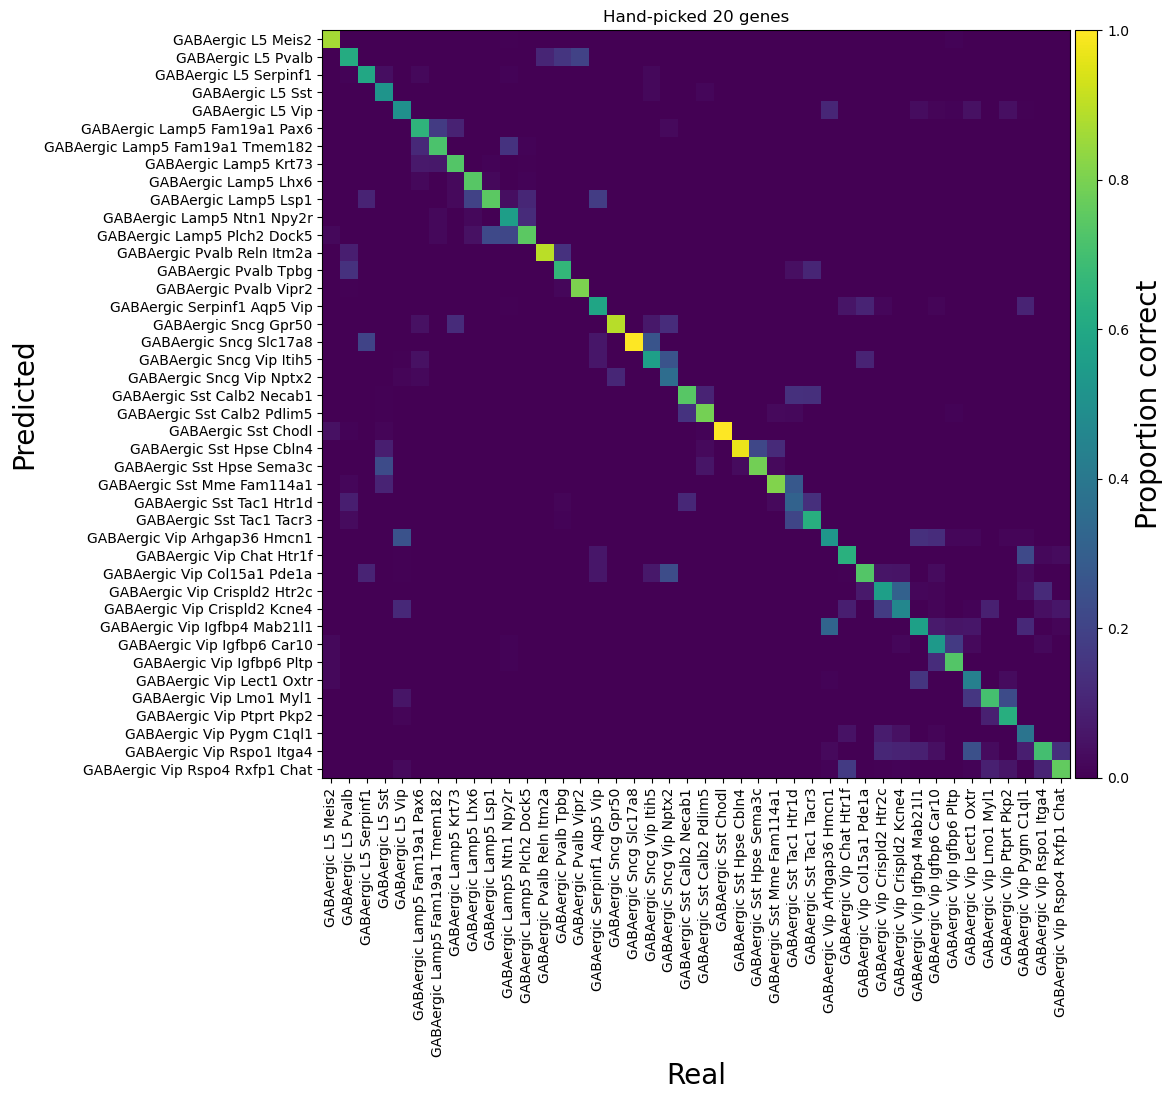

In [15]:
ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df, replace_na_with='None')
top_leaf = ranked_leaf_and_value['top_leaf'].values
fixed_confusion = mfishtools.get_confusion_matrix(cluster_call.loc[corr_matrix_df.index].values, top_leaf)

ax = mfishtools.plot_confusion_matrix(fixed_confusion)
ax.set_title('Hand-picked 20 genes')

# 10 hand-pikced + 10 algorithmically selected genes

In [32]:
ops_fn = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\results\ops_2024_11_18_01.json')
results_fn = ops_fn.name.replace('ops', 'results')
with open(ops_fn, 'r') as f:
    ops = json.load(f)
with open(output_folder / results_fn, 'r') as f:
    results = json.load(f)

In [59]:
built_panel = results['built_panel']
map_data = tpm_log2.loc[built_panel, keep_samples]

mapping_median_data = tpm_median_per_mapping.loc[built_panel, run_mappings]
corr_matrix_df = mfishtools.cor_tree_mapping(map_data,
                                            median_data=mapping_median_data,
                                            genes_to_map=built_panel)

[ 0.          0.          3.54598177  9.22949461 12.22866611 14.13421707
 15.90720795 17.61391881 36.15575808 40.54681027 46.16404308 46.77713339
 49.01408451 52.94117647 56.03976802 55.990058   58.84009942 60.13256007
 62.02154101 63.57912179 64.27506214 64.87158244]


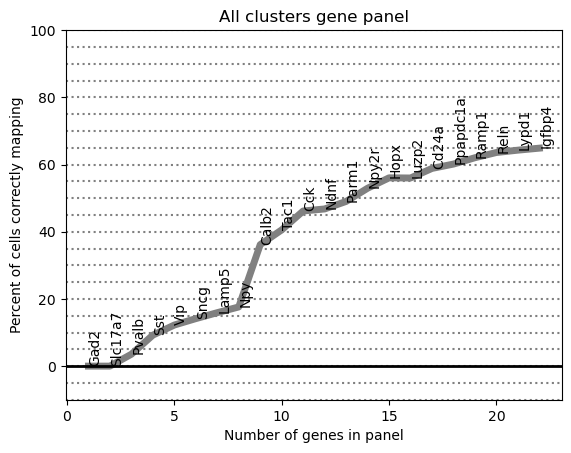

In [60]:
fig, ax = plt.subplots()
frac, ax = mfishtools.fraction_correct_with_genes(built_panel, map_data, mapping_median_data,
cluster_call=cluster_call, ax=ax)
print(frac)

Text(0.5, 1.0, 'Hand-picked 10 + algorithm 10 genes')

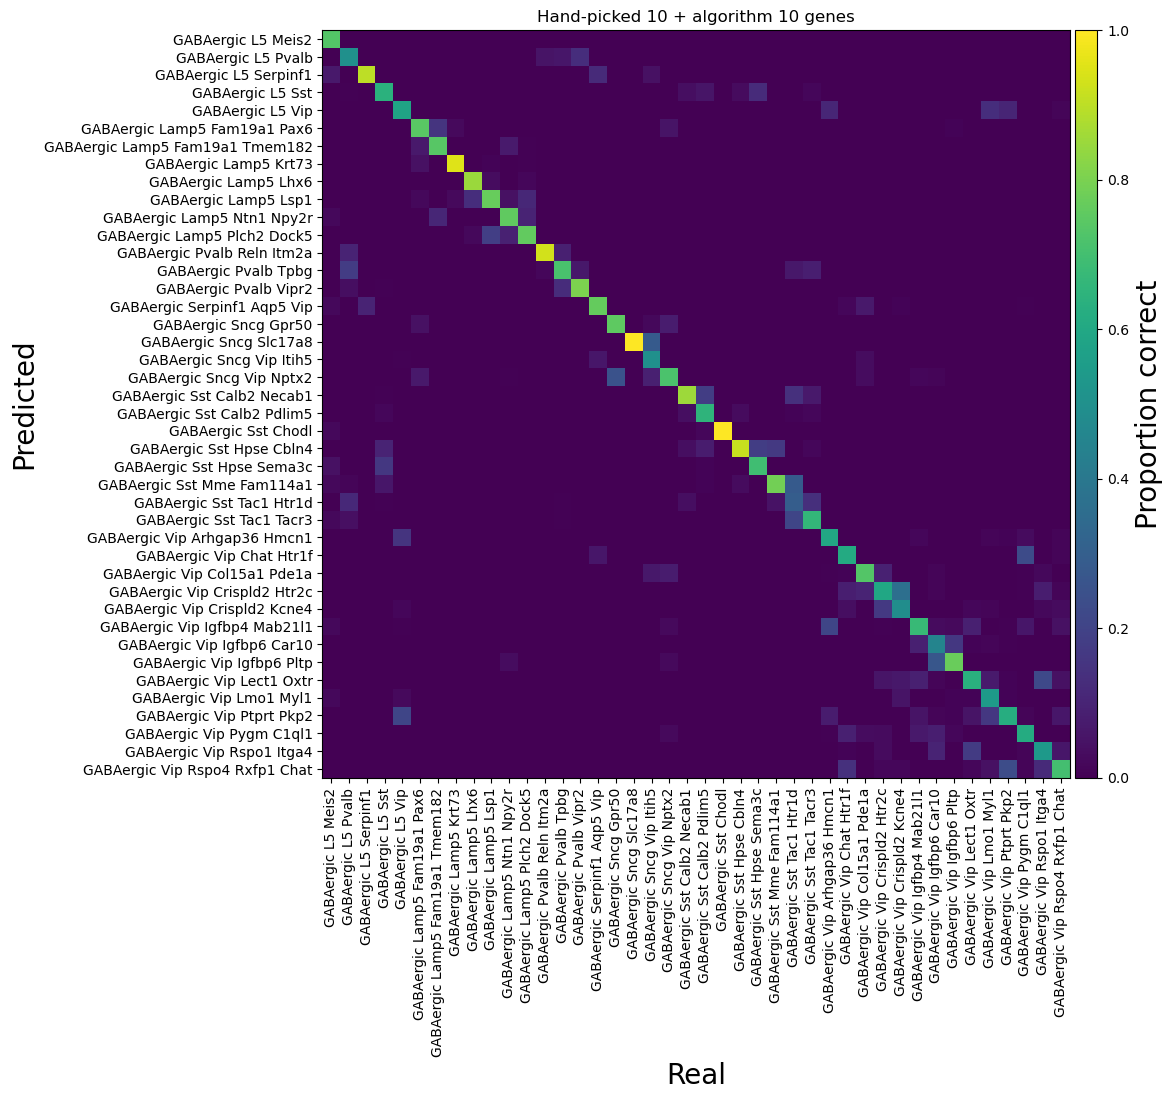

In [61]:
reload(mfishtools)
ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df, replace_na_with='None')
top_leaf = ranked_leaf_and_value['top_leaf'].values
new_confusion = mfishtools.get_confusion_matrix(cluster_call.loc[corr_matrix_df.index].values, top_leaf)

ax = mfishtools.plot_confusion_matrix(new_confusion, imshow_max=1.0)
ax.set_title('Hand-picked 10 + algorithm 10 genes')

Text(0.5, 1.0, 'Confusion difference (algorithm - hand-picked)')

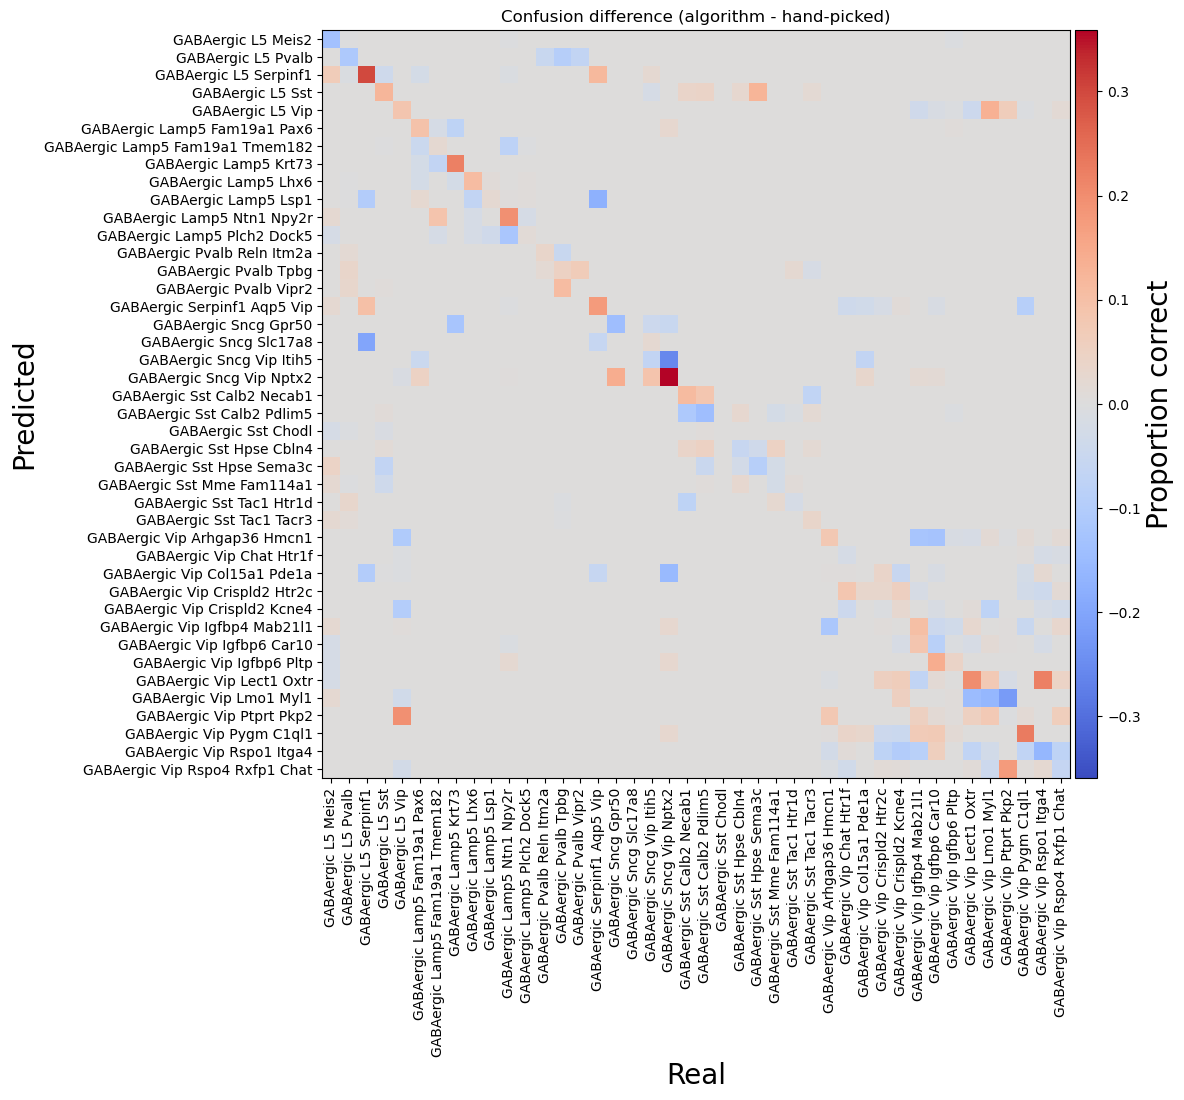

In [64]:
confusion_diff = new_confusion - fixed_confusion

reload(mfishtools)
ax = mfishtools.plot_confusion_matrix_diff(confusion_diff, cmap='coolwarm')
ax.set_title('Confusion difference (algorithm - hand-picked)')





# Random stuff

In [52]:
tpm_log2

,LS-14690_S02_E1-50,LS-14690_S03_E1-50,LS-14690_S05_E1-50,LS-14690_S06_E1-50,LS-14690_S07_E1-50,LS-14690_S08_E1-50,LS-14690_S09_E1-50,LS-14690_S10_E1-50,LS-14690_S11_E1-50,LS-14690_S12_E1-50,...,SQ-80004_S37_E1-50,SQ-80004_S38_E1-50,SQ-80004_S39_E1-50,SQ-80004_S40_E1-50,SQ-80004_S41_E1-50,SQ-80004_S42_E1-50,SQ-80004_S43_E1-50,SQ-80004_S44_E1-50,SQ-80004_S47_E1-50,SQ-80004_S48_E1-50
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
0610007P14Rik,5.802857,4.327806,5.619958,7.806159,7.723976,0.00000,0.000000,6.775325,6.722783,4.126390,...,8.105020,7.773431,0.000000,6.235863,7.134902,0.000000,8.738264,7.162667,0.0,7.625915
0610009B22Rik,7.472701,6.704577,5.094002,4.865556,7.280367,6.41268,6.574492,7.344601,5.187642,7.049125,...,3.836606,0.000000,6.683087,6.634895,6.747718,0.697103,0.000000,5.320197,0.0,7.900634
0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.822326,0.000000,0.000000,2.979984,2.867067,0.000000,0.000000,0.000000,0.0,2.737685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Text(0, 0.5, 'Pvalb')

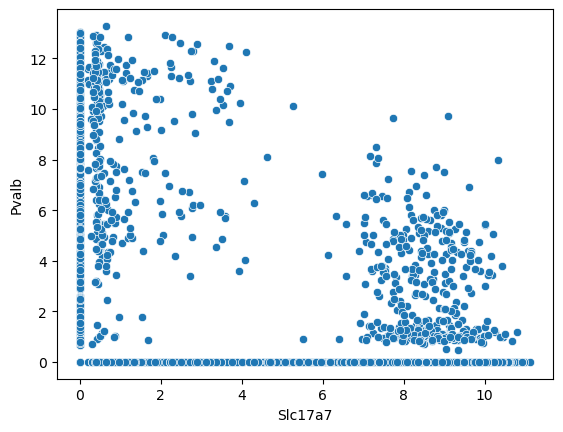

In [56]:
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(tpm_log2.T, x='Slc17a7', y='Pvalb')
ax.set_xlabel('Slc17a7')
ax.set_ylabel('Pvalb')

In [ ]:
annotation

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(tpm_log2.T, x='Slc17a7', y='Pvalb')
ax.set_xlabel('Slc17a7')
ax.set_ylabel('Pvalb')